Notebook to analyze interconnect power for transfering a matrix

In [70]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Switching activity (bit flips between successive rows of a vector)

In [1]:
import torch
import torch.nn as nn
import numpy as np
import sys
import os
from fxpmath import Fxp

# Add the directory containing utilis_ForsaV2.py to sys.path
custom_module_dir = os.path.abspath('../PyTorch-Models')  # Adjust the path accordingly
sys.path.append(custom_module_dir)
import utilis_ForsaV2
from utilis_ForsaV2 import *
# !pip install fxpmath\
from fxpmath import Fxp
import time
word_size  = 8
frac_size = 6
utilis_ForsaV2.word_size = word_size
utilis_ForsaV2.frac_size = frac_size
# from tensorboardX import SummaryWriter
# from transforms import *

In [2]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_size):
        super(SimpleClassifier, self).__init__()
        
        # Define the classifier layer with one output
        self.classifier = nn.Linear(input_size, 1)

    def forward(self, x):
        x = self.classifier(x)
        return x


In [76]:
# Function that takes a list of binary represenation of a vector and saves it in a file
def write_bin(mat, file_name):
    height = np.size(mat, 0)
    col = np.size(mat, 1)
    mat_lst = mat_2_bin(mat) # List of numbers in binary form
    with open(file_name, 'w') as f:
        for jj in range(0, col):
            for i in range(0, height):
                f.write(str(mat_lst[i][jj]))
                f.write('\n')
                
def compare_sw_sort_lst_out(mat_1, original_index, flat_start, isconv=True): #Using full row as one vector
    if isconv==True:
        b1_conv_wt_mat = torch.flatten(mat_1, flat_start).cpu().detach().numpy()
    else:
        b1_conv_wt_mat = mat_1.cpu().detach().numpy()
    fixed_point_matrix = (b1_conv_wt_mat * (2**frac_size)).astype(int)
    fixed_point_matrix_original = fixed_point_matrix.copy()
    fixed_point_matrix_sorted = fixed_point_matrix[original_index]#[:] #########sortFullMatrix_V2##############
    sw_vector = calc_sw_act_V2(fixed_point_matrix_original)
    ###################################### after sorting ######################################
    sw_vector_sorted = calc_sw_act_V2(fixed_point_matrix_sorted)
    print('Switching before sorting', np.average(sw_vector))
    print('Switching after sorting', np.average(sw_vector_sorted))
    print('Percentage of switching reduction', (np.average(sw_vector) - np.average(sw_vector_sorted))*100/np.average(sw_vector), '%')
    sw_redc_rate = (np.average(sw_vector) - np.average(sw_vector_sorted))*100/np.average(sw_vector)
    return mat_1[original_index], sw_redc_rate, sw_vector, sw_vector_sorted # Returning original_index to rearrange activation maps

    

In [31]:
# Plot the list of bit flips for every row fetch to see the pattern

In [49]:
low_n = 0
high_n = 256
data_size = [16, 32, 64, 128, 256, 512]
sw_before_lst = []
sw_after_lst = []
for vect_size in data_size:
    file_name = 'bin_8bit_' + str(vect_size) + '.txt'
    file_name_sorted = 'bin_8bit_sorted_' + str(vect_size) + '.txt'
    model = SimpleClassifier(vect_size)
    _, new_indx1 = sortFullMatrix_V2(model.classifier.weight.data.T)
    rnd_int, sw_red_rate, sw_before, sw_after  = compare_sw_sort_lst_out(model.classifier.weight.data.T, new_indx1, -1, isconv=False)
    mat = torch.flatten(model.classifier.weight.data.T.cpu(), -1*1).numpy()
    write_bin(mat, file_name)
    mat = torch.flatten(rnd_int.cpu(), -1*1).numpy()
    write_bin(mat, file_name_sorted)
    sw_before_lst.append(sw_before)
    sw_after_lst.append(sw_after)
    

Switching before sorting 5.0
Switching after sorting 1.2666666666666666
Percentage of switching reduction 74.66666666666666 %
Switching before sorting 4.032258064516129
Switching after sorting 0.6774193548387096
Percentage of switching reduction 83.2 %
Switching before sorting 4.26984126984127
Switching after sorting 0.2857142857142857
Percentage of switching reduction 93.30855018587361 %
Switching before sorting 4.039370078740157
Switching after sorting 0.13385826771653545
Percentage of switching reduction 96.68615984405459 %
Switching before sorting 3.937254901960784
Switching after sorting 0.043137254901960784
Percentage of switching reduction 98.90438247011951 %
Switching before sorting 3.888454011741683
Switching after sorting 0.019569471624266144
Percentage of switching reduction 99.49672873678914 %


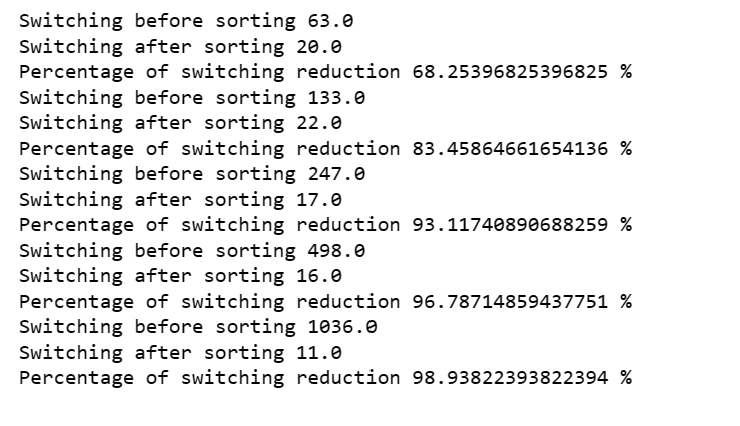

# Interconnect switching activity from Cadence   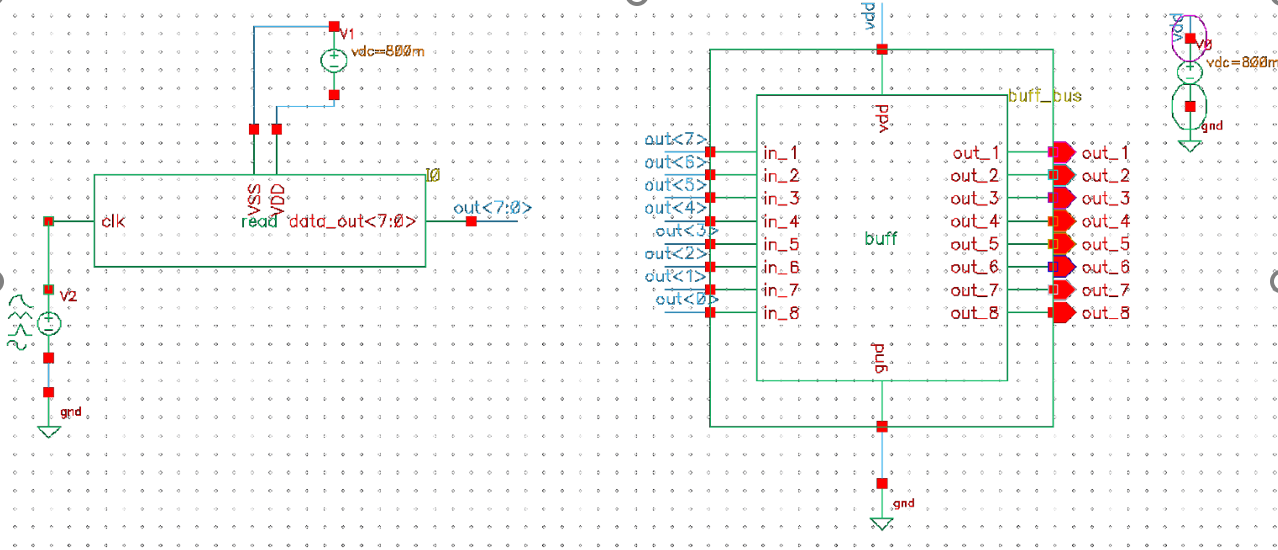

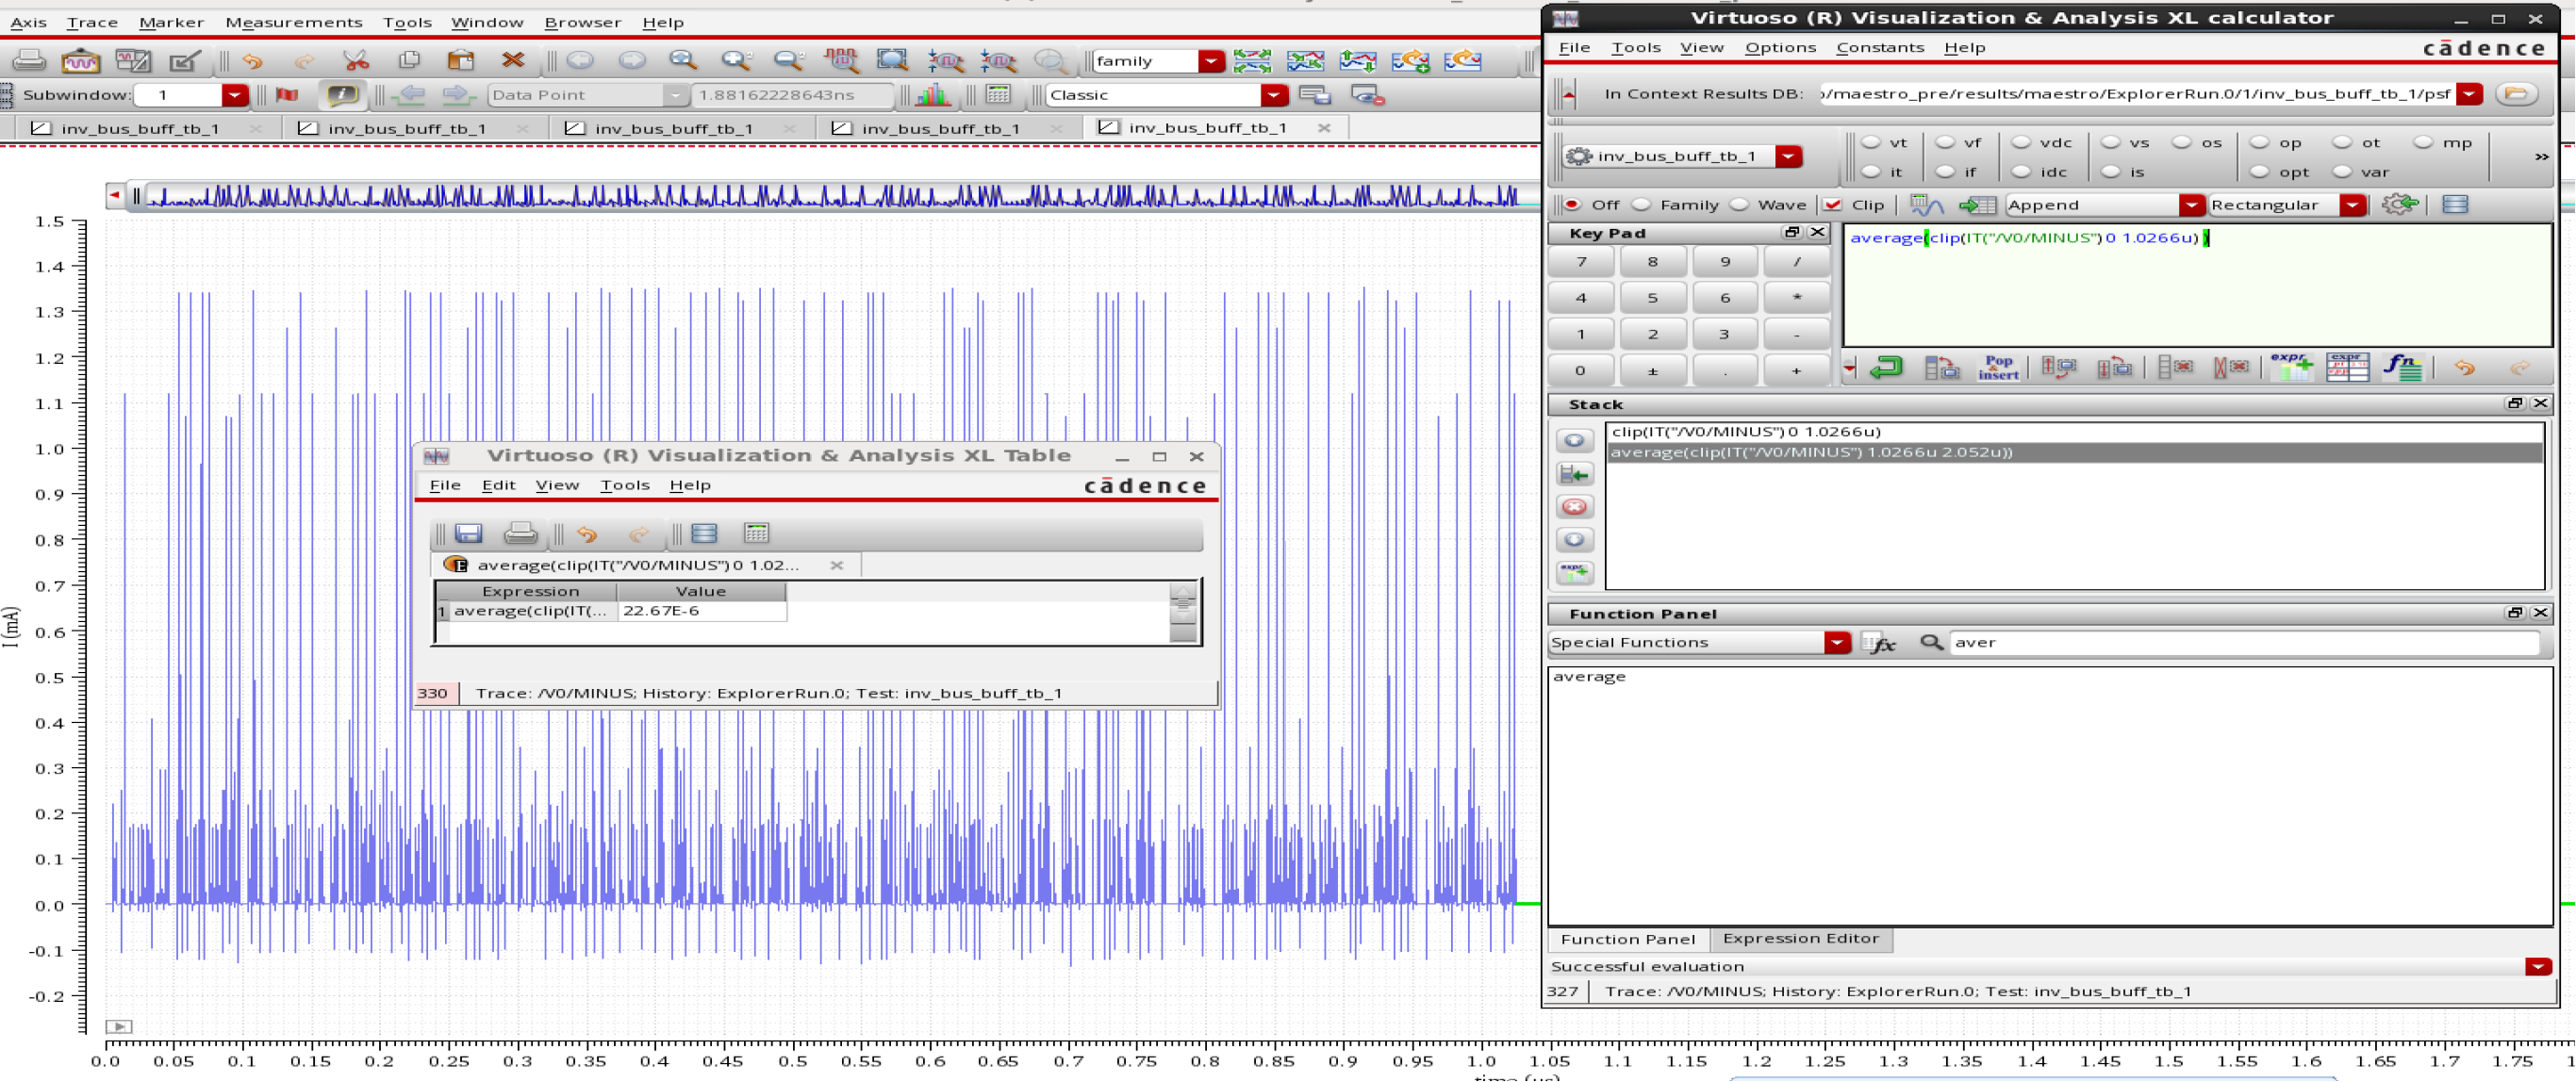

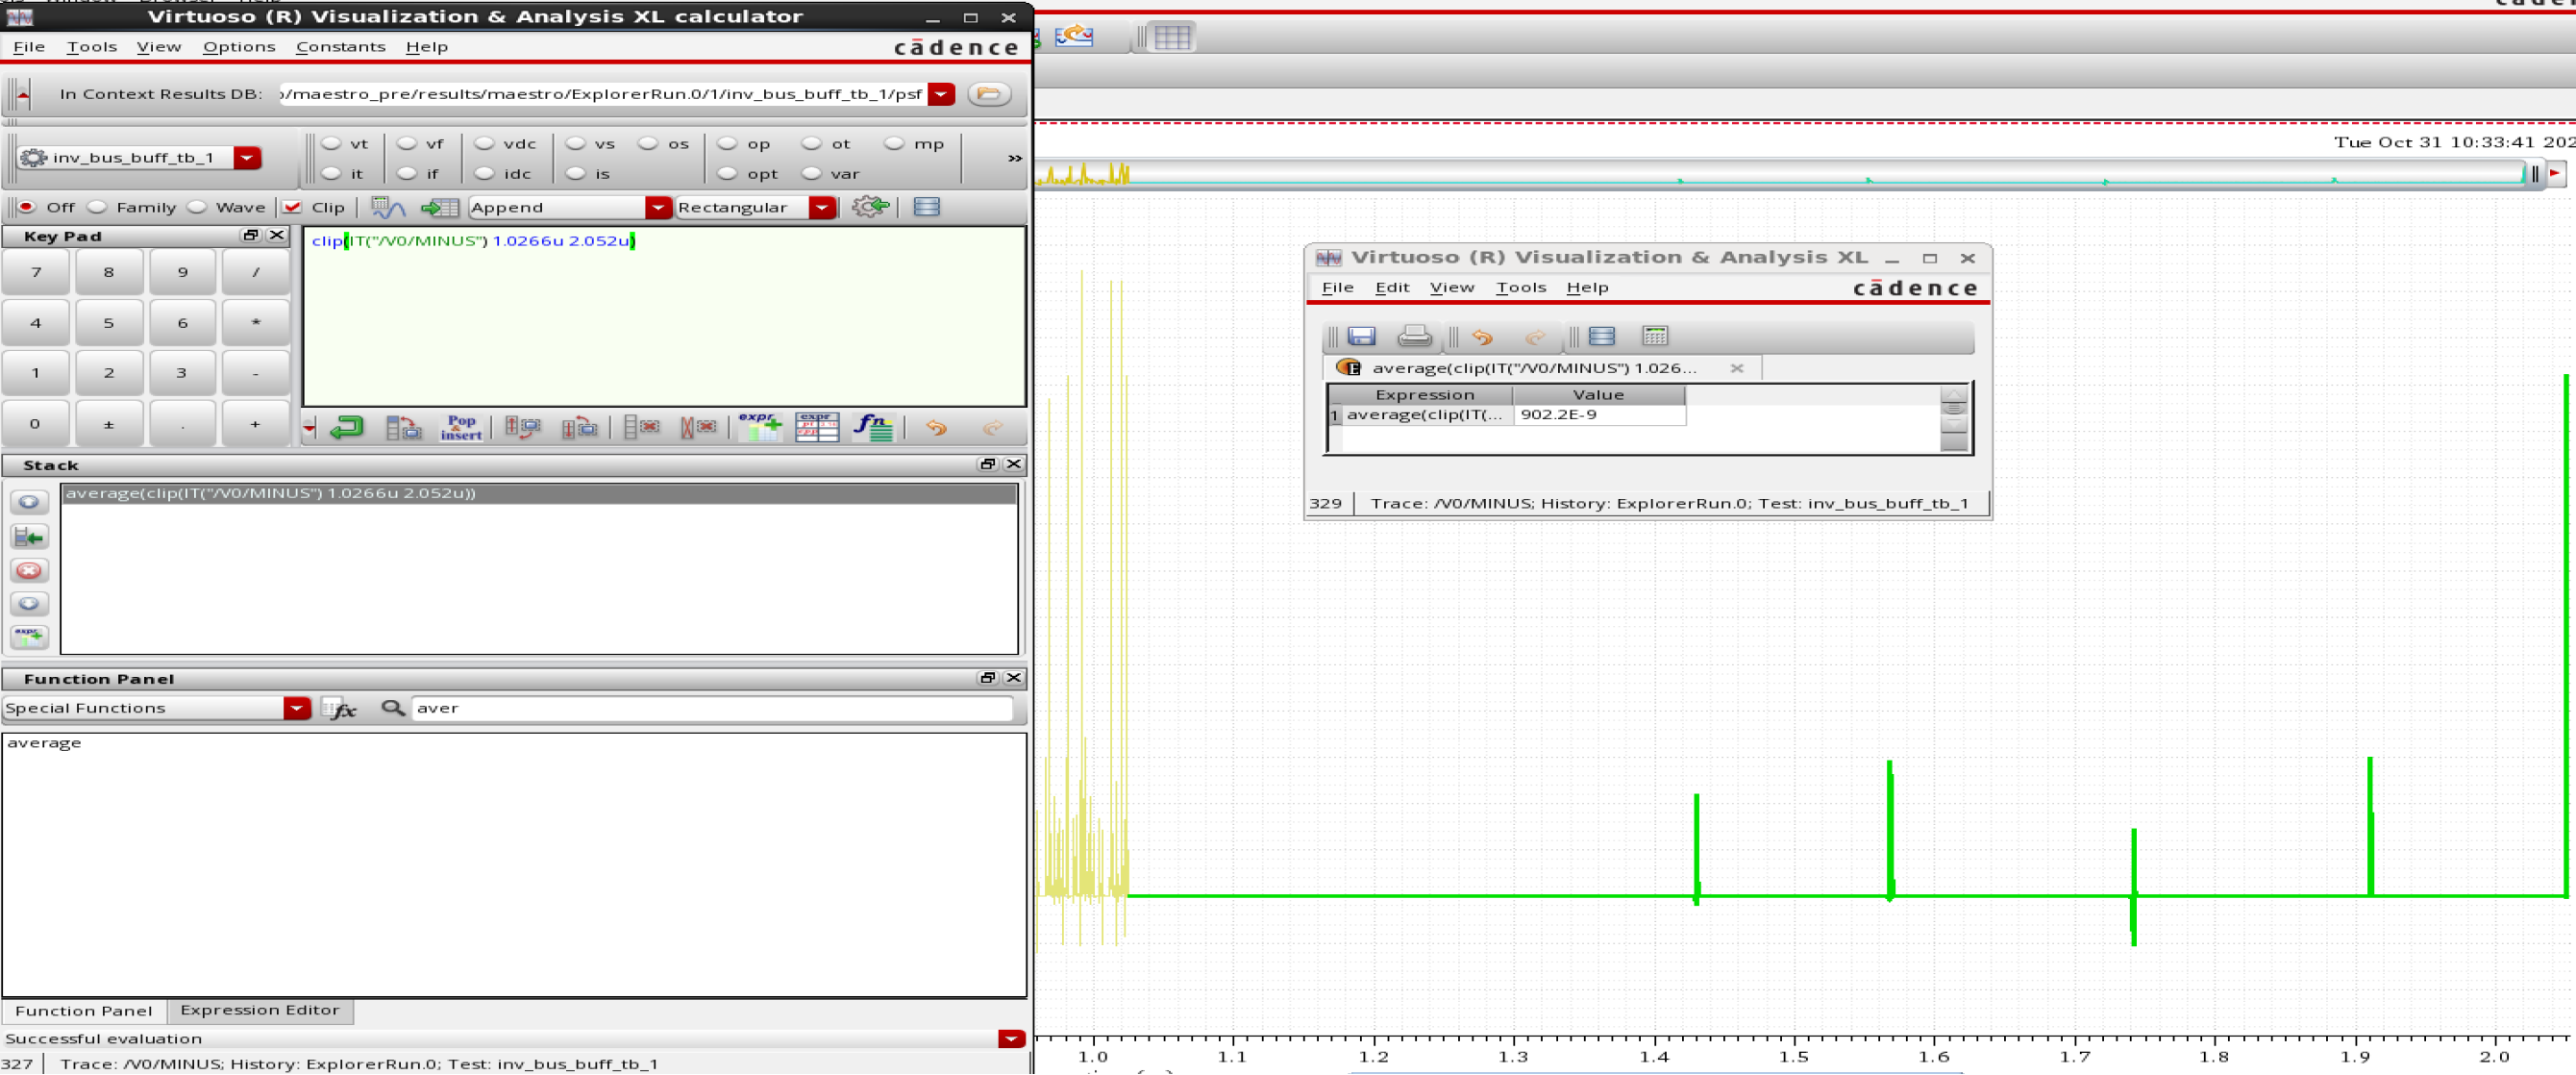

In [52]:
# For 512 bytes
pow_avg512 = 22.67e-6
pow_avg_sorted512 = 902.2e-9
sw_saving = (pow_avg512-pow_avg_sorted512)/pow_avg512
sw_saving

0.9602029113365682

Dynamic power saving while transfering 16 bytes 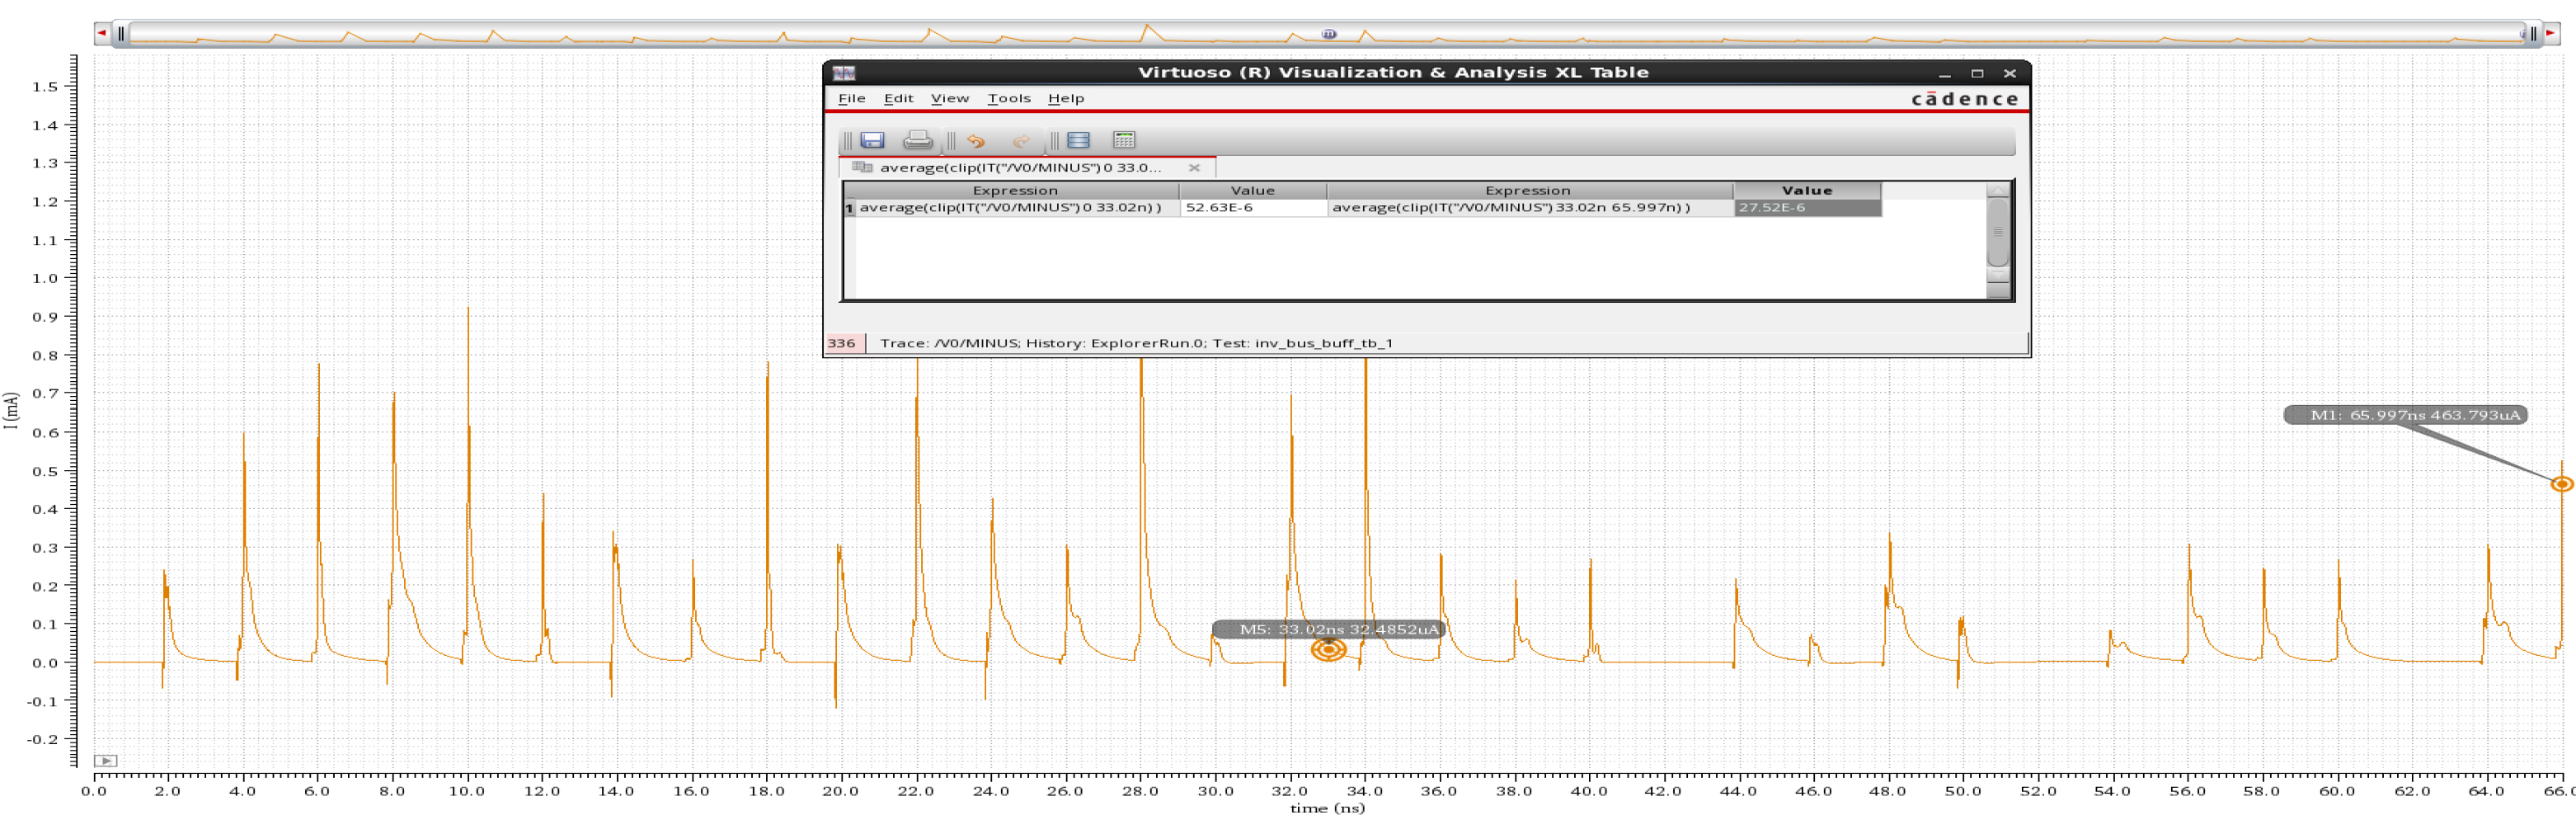

In [63]:

pow_avg16 = 52.63E-6
pow_avg_sorted16 = 27.52E-6
sw_saving16 = (pow_avg16-pow_avg_sorted16)/pow_avg16
sw_saving16

0.4771043131293939

Dynamic power saving while transfering 32 bytes 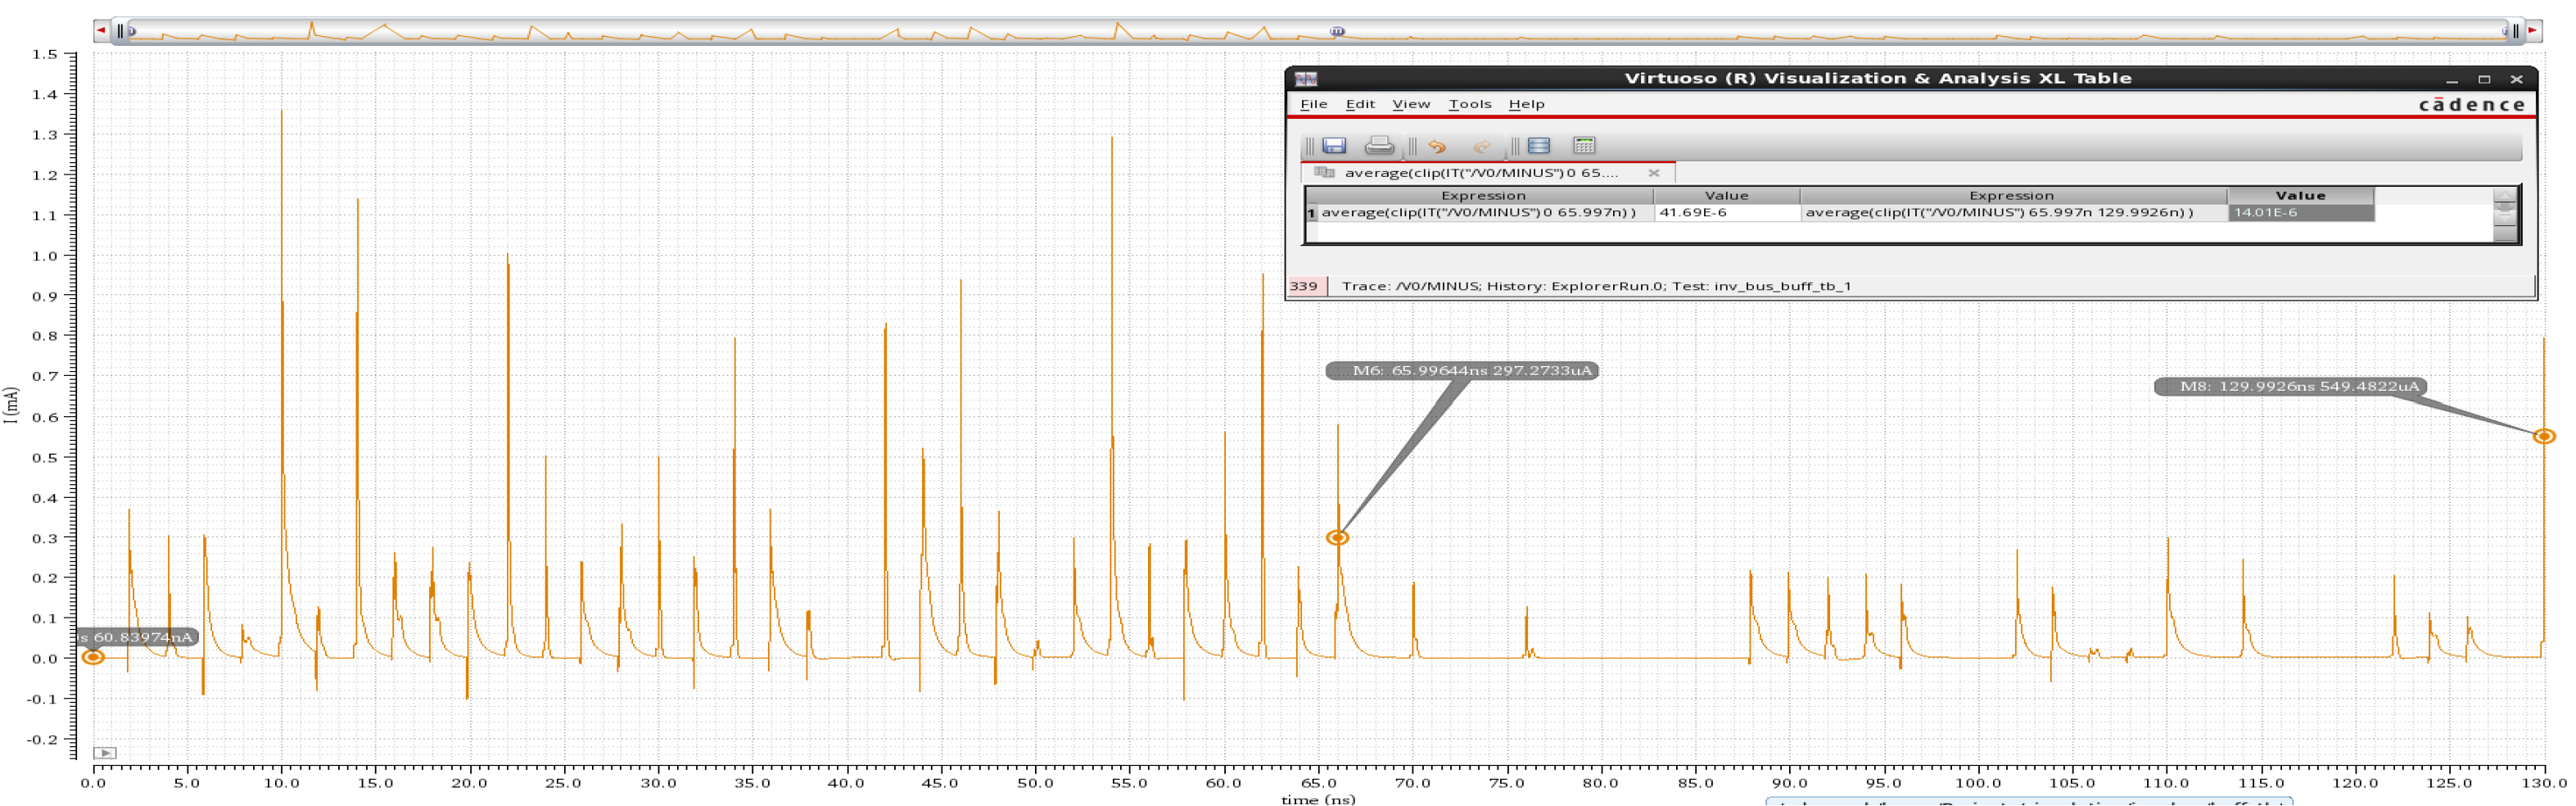

In [62]:

pow_avg32 = 41.69E-6
pow_avg_sorted32 = 14.01E-6
sw_saving32 = (pow_avg32-pow_avg_sorted32)/pow_avg32
sw_saving32

0.6639481890141521

Dynamic power saving while transfering 64 bytes 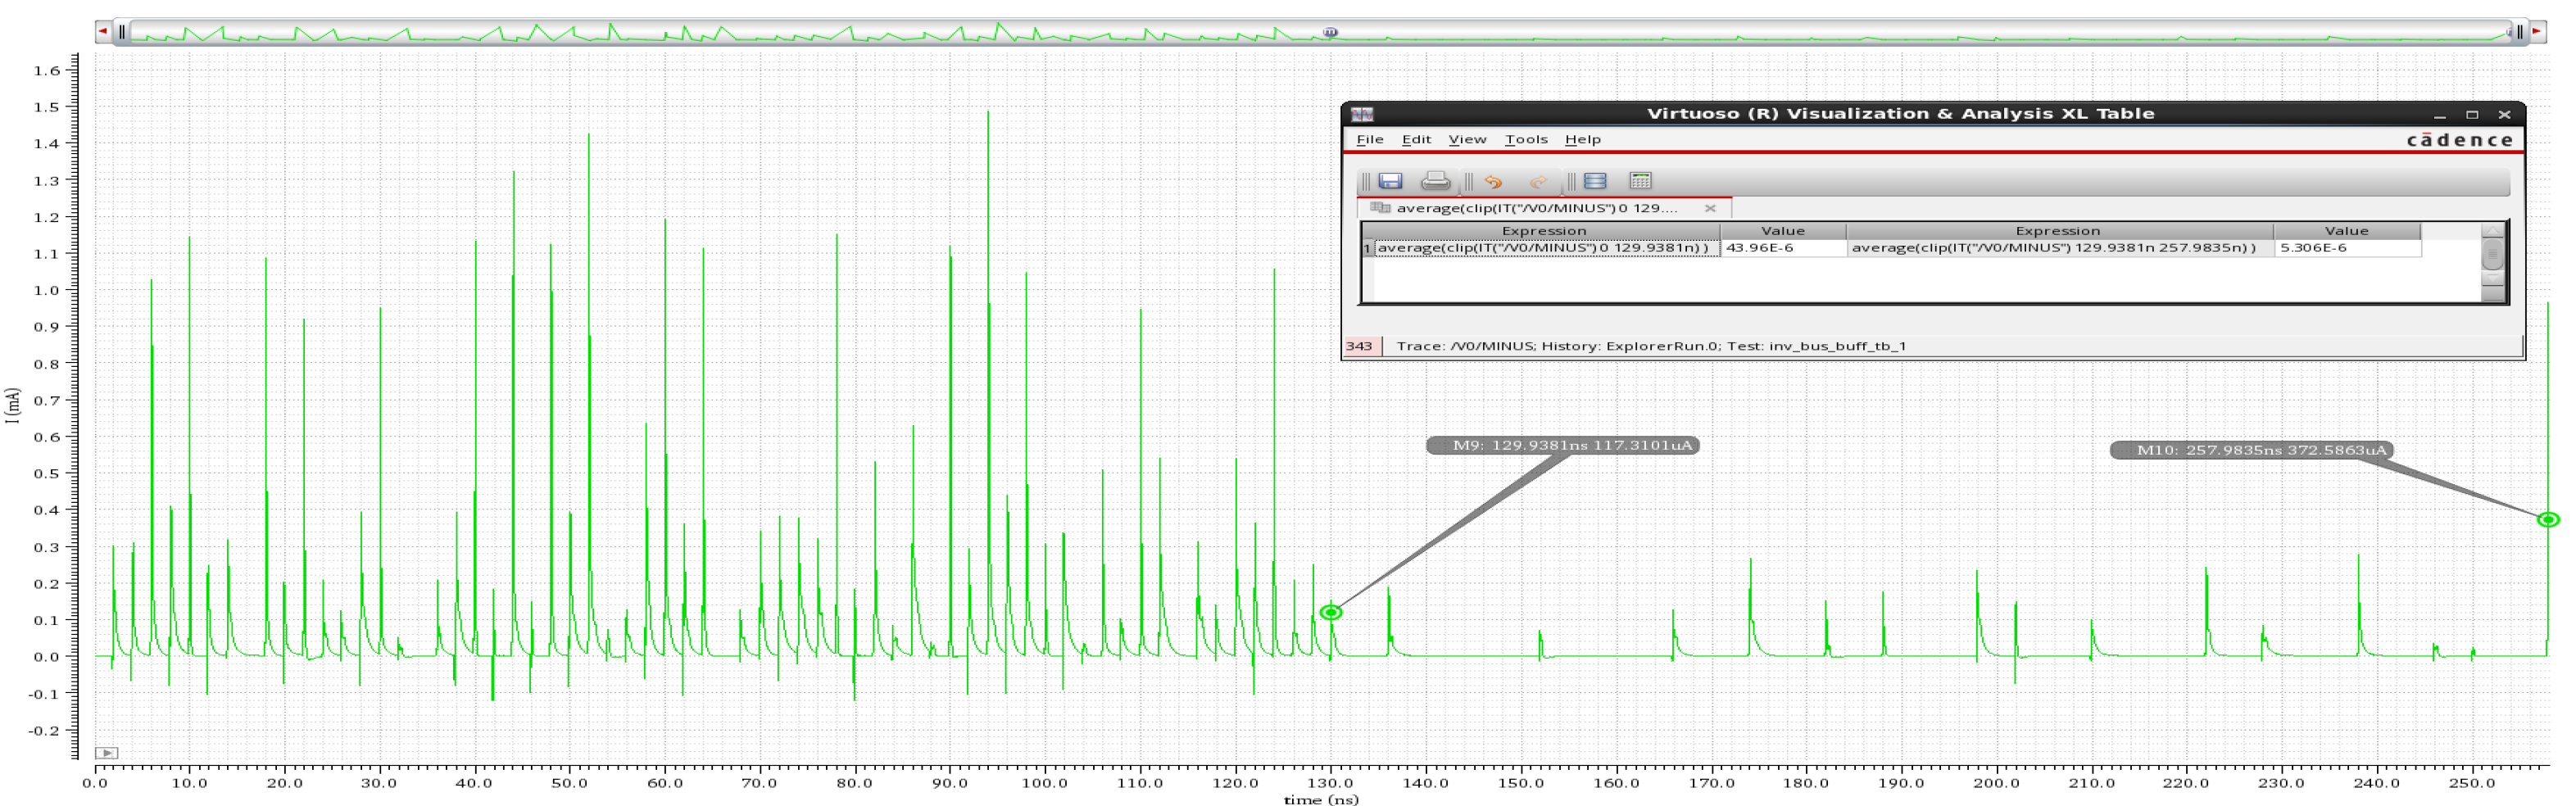

In [61]:
# Dynamic power saving while transfering 64 bytes
pow_avg64 = 43.96E-6
pow_avg_sorted64 = 5.306E-6
sw_saving64 = (pow_avg64-pow_avg_sorted64)/pow_avg64
sw_saving64

0.8792993630573248

Dynamic power saving while transfering 128 bytes 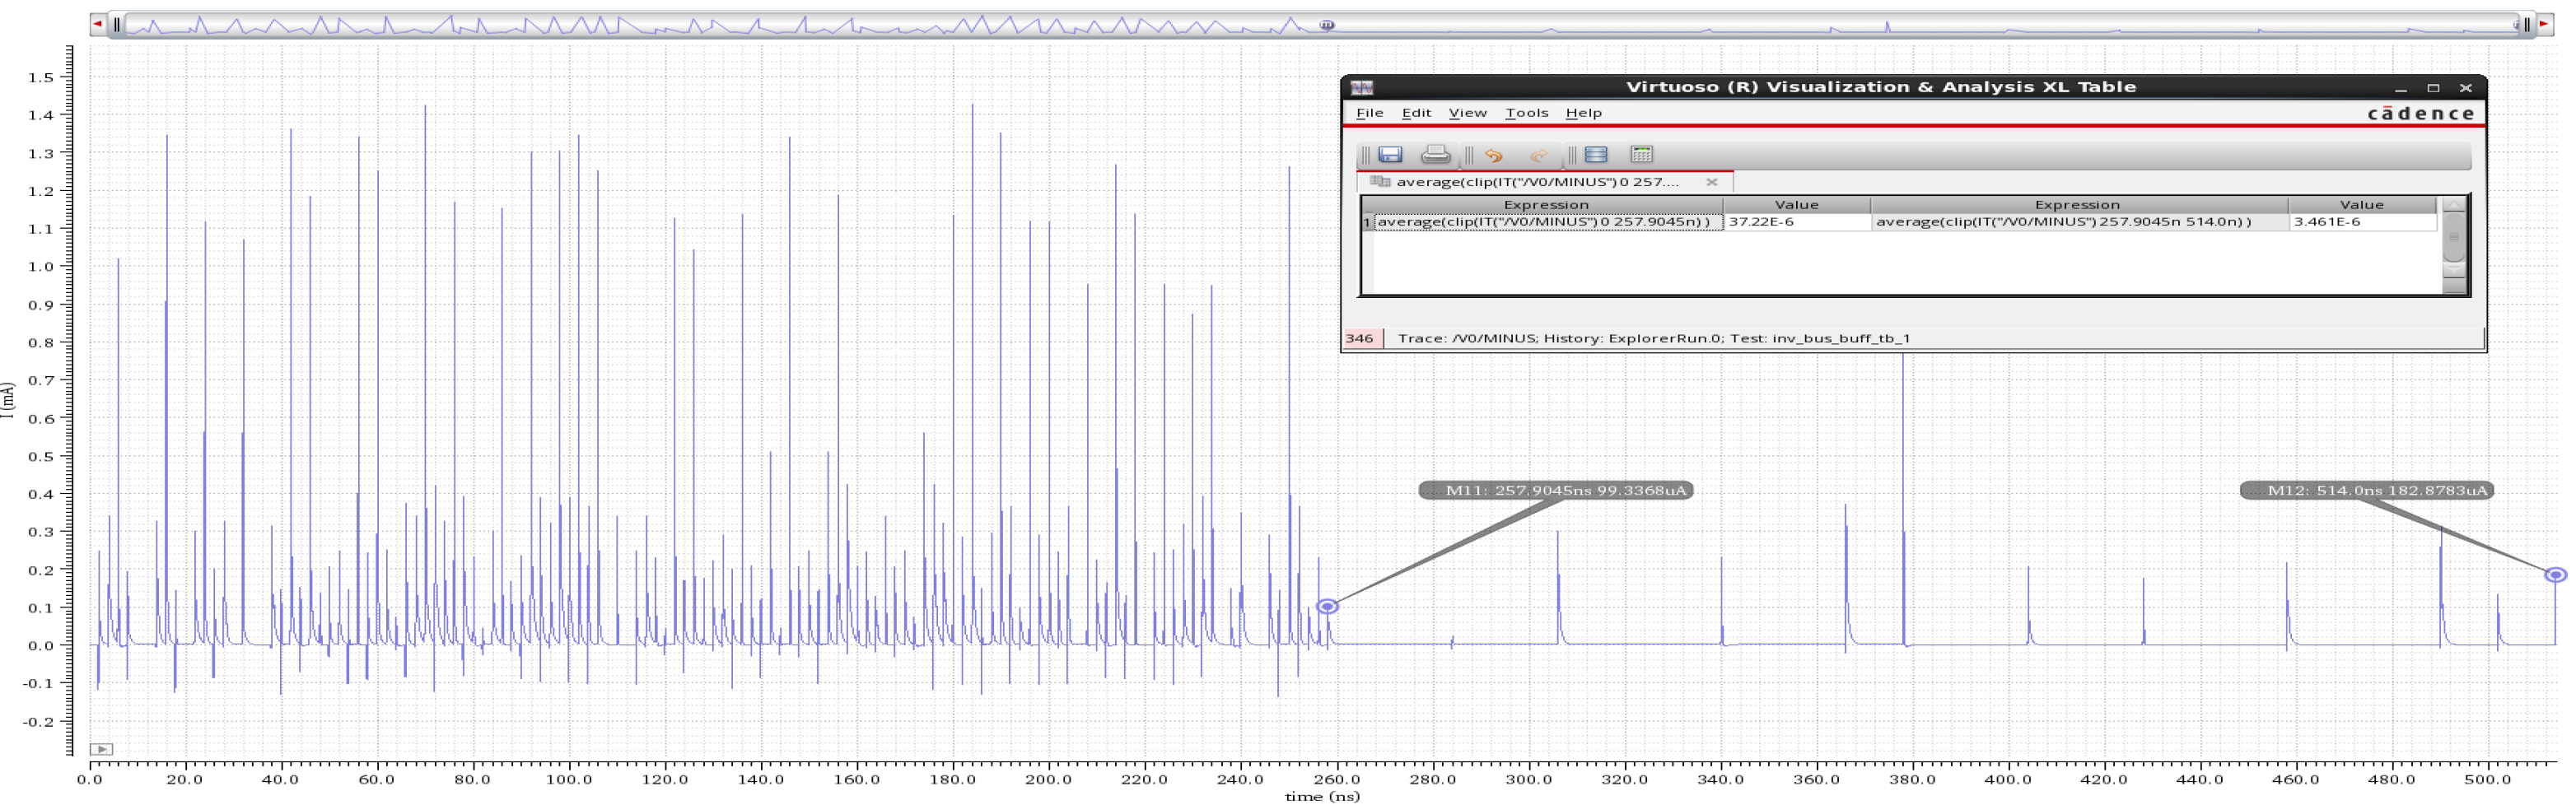

In [60]:
# Dynamic power saving while transfering 64 bytes
pow_avg128 = 37.22E-6
pow_avg_sorted128 = 3.461E-6
sw_saving128 = (pow_avg128-pow_avg_sorted128)/pow_avg128
sw_saving128

0.9070123589468028

Dynamic power saving while transfering 256 bytes 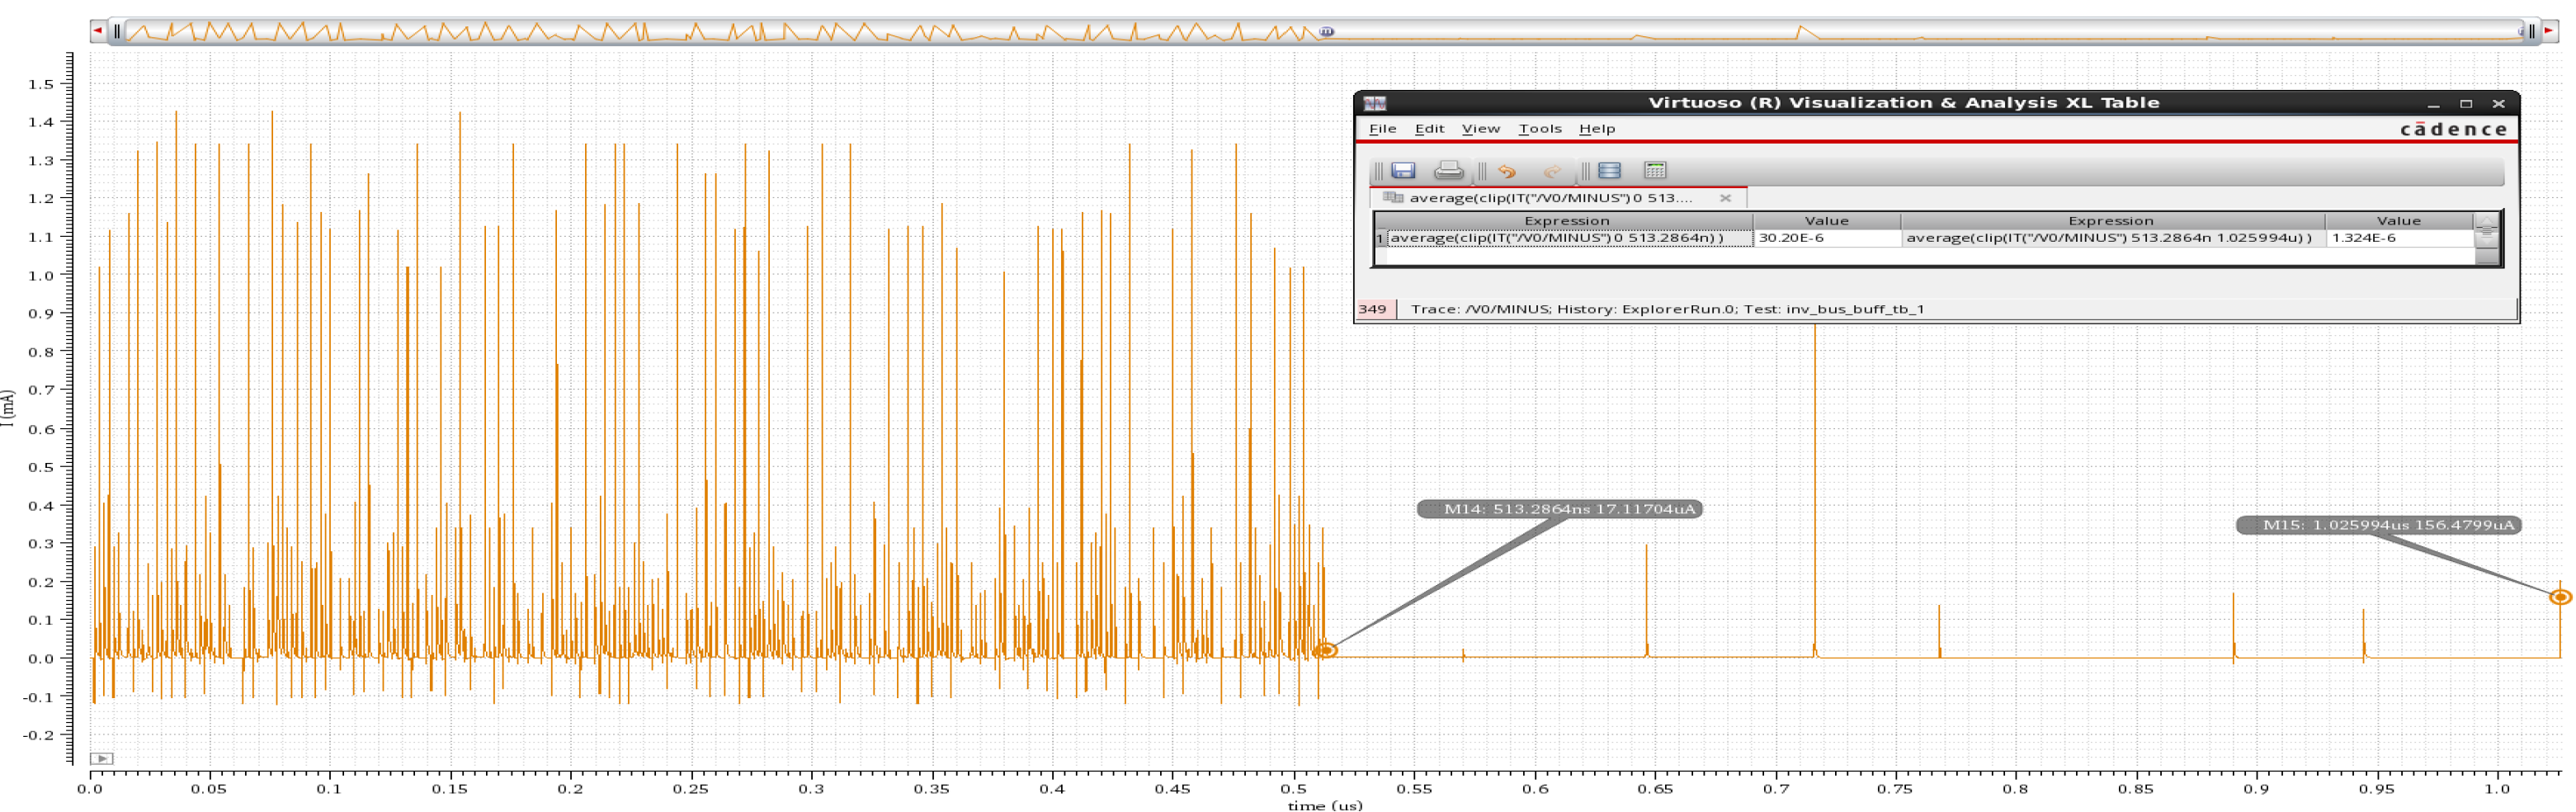

In [64]:
# Dynamic power saving while transfering 64 bytes
pow_avg256 = 30.20E-6
pow_avg_sorted256 = 1.324E-6
sw_saving256 = (pow_avg256-pow_avg_sorted256)/pow_avg256
sw_saving256

0.956158940397351

Dynamic power saving while transfering 512 bytes 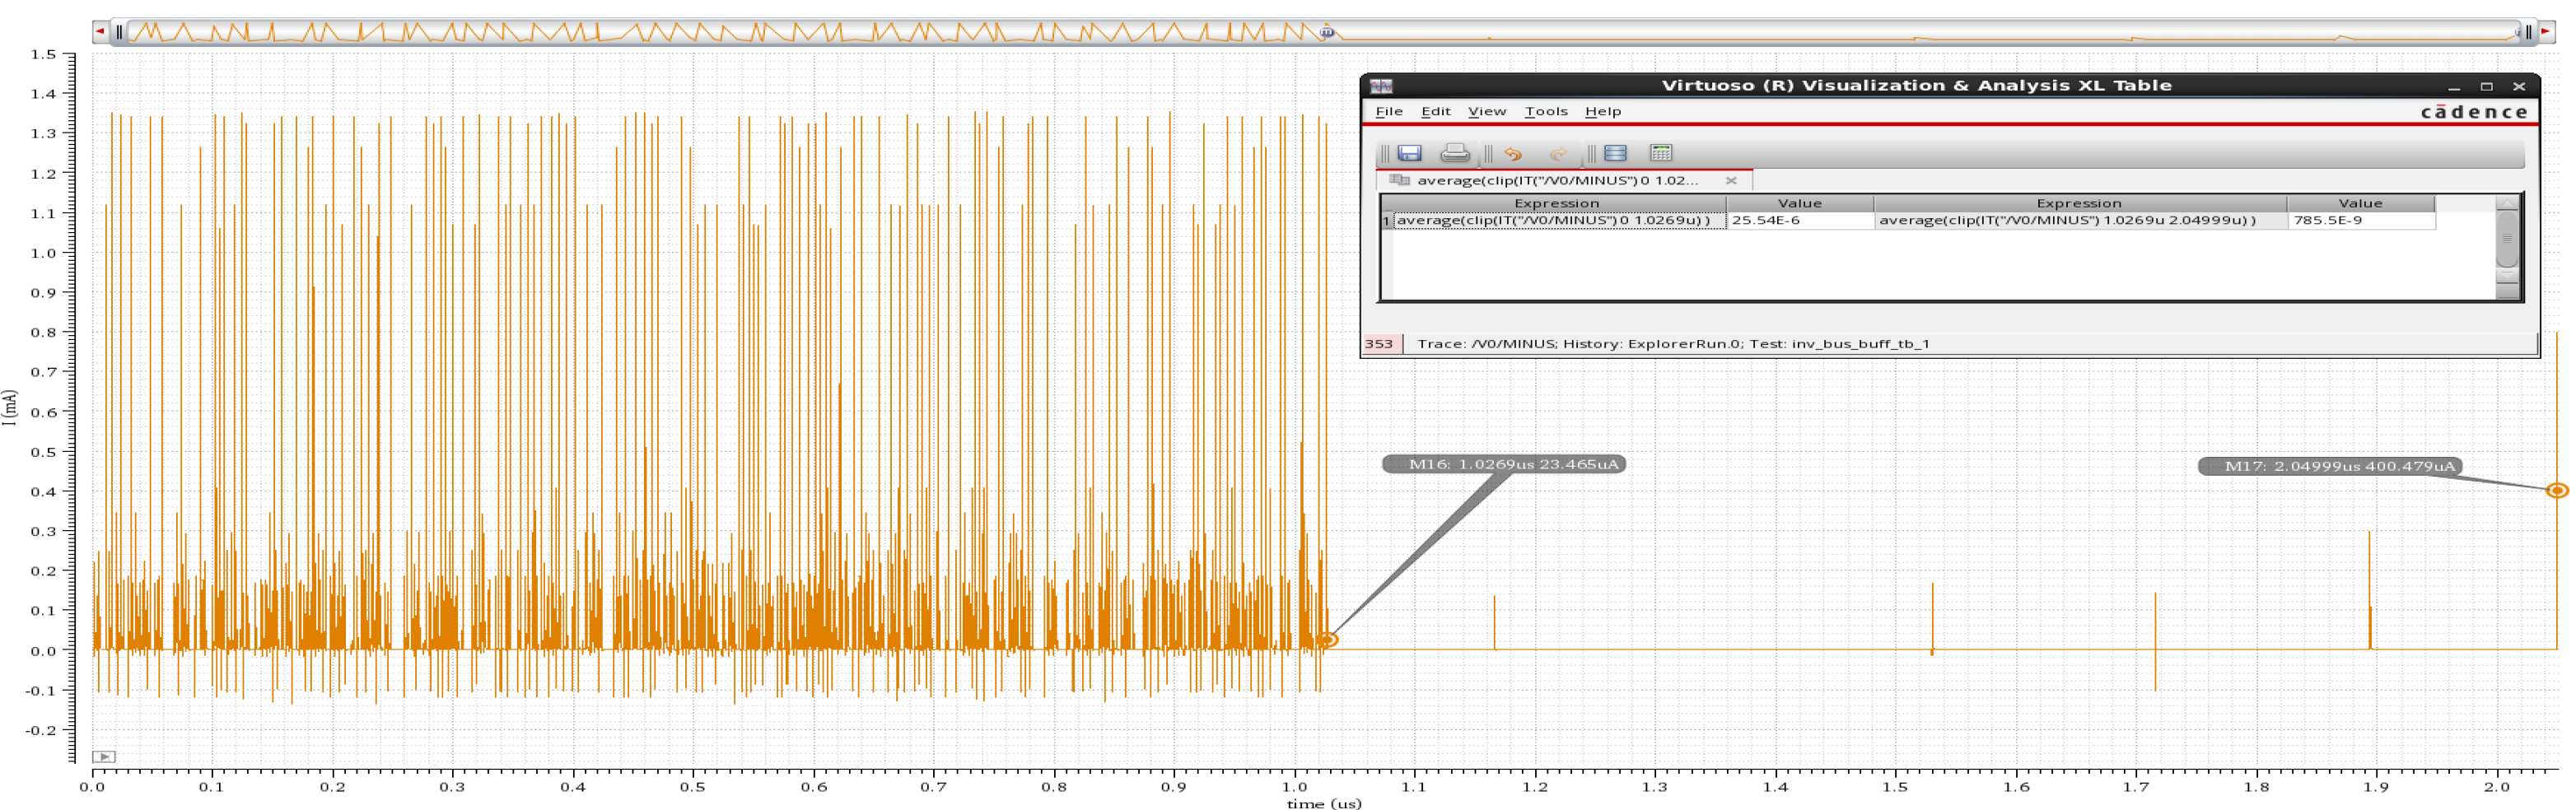

In [67]:
# Dynamic power saving while transfering 64 bytes
pow_avg512 = 25.54E-6
pow_avg_sorted512 = 785.5E-9
sw_saving512 = (pow_avg512-pow_avg_sorted512)/pow_avg512
sw_saving512

0.9692443226311668

# Switching activity analsys using first layer of squeezenet

In [68]:
import torch
import torch.nn as nn
import numpy as np
from utilis_ForsaV2 import *
import utilis_ForsaV2
# !pip install fxpmath\
from fxpmath import Fxp
import time
word_size  = 8
frac_size = 6
utilis_ForsaV2.word_size = word_size
utilis_ForsaV2.frac_size = frac_size
# from tensorboardX import SummaryWriter
# from transforms import *


In [77]:
# from models_cust import *
model = torch.hub.load('pytorch/vision:v0.10.0', 'squeezenet1_0', pretrained=True)
model.eval()

Using cache found in C:\Users\huruy/.cache\torch\hub\pytorch_vision_v0.10.0


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [78]:
bit_size = 8
file_name = 'layer_1_' + str(bit_size) + 'bit.txt'
file_name_sorted = 'layer_1_sorted_' + str(bit_size) + 'bit.txt'

_, new_indx1 = sortFullMatrix_V2(model.features[0].weight)
mat_original = model.features[0].weight.data
rnd_int, sw_red_rate, sw_before, sw_after = compare_sw_sort(model.features[0].weight.data, new_indx1, -3)
print(rnd_int.shape)
mat = torch.flatten(mat_original.cpu(), -3).numpy()
print(mat.shape)
write_bin(mat, file_name)
mat = torch.flatten(rnd_int.cpu(), -3).numpy()
write_bin(mat, file_name_sorted)



Switching before sorting 53762.0
Switching after sorting 43609.0
Percentage of switching reduction 18.885086120308024 %
torch.Size([96, 3, 7, 7])
(96, 147)


# BACKUP CELLS

In [56]:
import csv
import numpy as np

def print_sw_saving(file_name):
    with open(file_name, mode ='r')as file:
        csvFile = csv.reader(file)
        next(csvFile) # This is to skip the first header row
        data = []
        # displaying the contents of the CSV file
        for lines in csvFile:
            data.append(lines)
        data_arr = np.array(data)
        samples, _ = data_arr.shape
        print('data shape is ', data_arr.shape, 'for samples of ', samples)
        data_arrfp = data_arr.astype(float)
        pow_dyn = np.sum(data_arrfp[0:samples//2, 1])
        pow_dyn_sorted = np.sum(data_arrfp[samples//2+1:samples, 1])
        perc_red = (pow_dyn-pow_dyn_sorted)*100/pow_dyn  
        print('dynamic power avg before sorting :', pow_dyn)
        print('dynamic power avg after sorting :', pow_dyn_sorted)
        print('percentage saving after sorting :', perc_red)

data_size = [16, 32, 64, 128, 256, 512]
for vect_size in data_size:
    print('=================================== New data size =======================================')
#     print('Dynamic power saving for a data size of ', str(vect_size), 'from pre layout power traces')
#     file_name = './PowerTraces/buff_pre' + str(vect_size) + '.csv'
#     print_sw_saving(file_name)
    print('Dynamic power saving for a data size of ', str(vect_size), 'from post layout power traces')
    file_name_sorted = './PowerTraces/buff_post' + str(vect_size) + '.csv'
    print_sw_saving(file_name_sorted)

=================================== New data size =======================================
Dynamic power saving for a data size of  16 from post layout power traces
data shape is  (1812, 2) for samples of  1812
dynamic power avg before sorting : 0.1589292902904169
dynamic power avg after sorting : 0.08667825907445965
percentage saving after sorting : 45.461117383668224
=================================== New data size =======================================
Dynamic power saving for a data size of  32 from post layout power traces
data shape is  (3048, 2) for samples of  3048
dynamic power avg before sorting : 0.2471366338862974
dynamic power avg after sorting : 0.12159236527134744
percentage saving after sorting : 50.7995381505076
=================================== New data size =======================================
Dynamic power saving for a data size of  64 from post layout power traces
data shape is  (4943, 2) for samples of  4943
dynamic power avg before sorting : 0.3348455877226

In [43]:
import csv
import numpy as np
# opening the CSV file
with open('./PowerTraces/buff_pre16.csv', mode ='r')as file:
    # reading the CSV file
    csvFile = csv.reader(file)
    next(csvFile) # This is to skip the first header row
    data = []
    # displaying the contents of the CSV file
    for lines in csvFile:
        data.append(lines)


1576


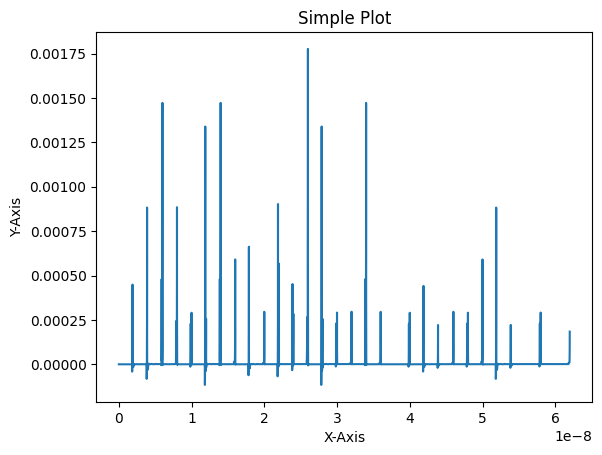

In [207]:
import matplotlib.pyplot as plt
import numpy as np
# plot(data)
# Create a basic line plot
data_arr = np.array(data)
samples, _ = data_arr.shape
print(samples)
data_arrfp = data_arr.astype(float)
plt.plot(data_arrfp[:-70, 0], data_arrfp[:-70, 1])

# Add labels and a title
plt.xlabel('X-Axis')
plt.ylabel('Y-Axis')
plt.title('Simple Plot')

# Display the plot (you can also save it to a file)
plt.show()

In [208]:
np.average(data_arrfp[:, 1])

0.00011353518114705877

In [209]:
np.sum(data_arrfp[:, 1])

0.17893144548776463

In [210]:
(np.average(data_arrfp[0:samples//2, 1]) - np.average(data_arrfp[samples//2+1:samples, 1]))/np.average(data_arrfp[0:samples//2, 1])

0.510999766850401

In [214]:
data_arrfp[samples//2+1:samples, 1].shape

(787,)

In [200]:
import csv
import numpy as np
# opening the CSV file
with open('./PowerTraces/buff_post16.csv', mode ='r')as file:
    # reading the CSV file
    csvFile = csv.reader(file)
    next(csvFile) # This is to skip the first header row
    data = []
    # displaying the contents of the CSV file
    for lines in csvFile:
        data.append(lines)

16014


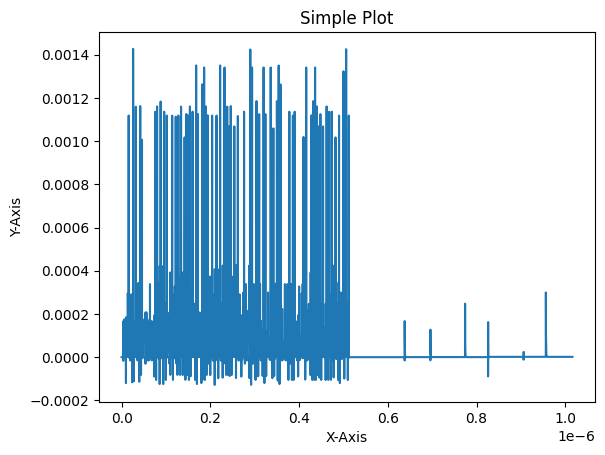

In [201]:
import matplotlib.pyplot as plt
import numpy as np
# plot(data)
# Create a basic line plot
data_arr = np.array(data)
samples, _ = data_arr.shape
print(samples)
data_arrfp = data_arr.astype(float)
plt.plot(data_arrfp[:-70, 0], data_arrfp[:-70, 1])

# Add labels and a title
plt.xlabel('X-Axis')
plt.ylabel('Y-Axis')
plt.title('Simple Plot')

# Display the plot (you can also save it to a file)
plt.show()

In [202]:
np.average(data_arrfp[:, 1])

0.00011256039961306511

In [203]:
np.sum(data_arrfp[:, 1])

1.8025422394036248

In [204]:
(np.average(data_arrfp[0:samples//2, 1]) - np.average(data_arrfp[samples//2+1:samples, 1]))/np.average(data_arrfp[0:samples//2, 1])

0.3876902084322213

samples

In [205]:
samples

16014

In [13]:
def compare_sw_sort_lst_out(mat_1, original_index, flat_start, isconv=True): #Using full row as one vector
    if isconv==True:
        b1_conv_wt_mat = torch.flatten(mat_1, flat_start).cpu().detach().numpy()
    else:
        b1_conv_wt_mat = mat_1.cpu().detach().numpy()
    fixed_point_matrix = (b1_conv_wt_mat * (2**frac_size)).astype(int)
    fixed_point_matrix_original = fixed_point_matrix.copy()
    fixed_point_matrix_sorted = fixed_point_matrix[original_index]#[:] #########sortFullMatrix_V2##############
    sw_vector = calc_sw_act_V2_wire(fixed_point_matrix_original)
    ################### after sorting
    sw_vector_sorted = calc_sw_act_V2_wire(fixed_point_matrix_sorted)
    print('Switching before sorting', np.mean(sw_vector))
    print('Switching after sorting', np.mean(sw_vector_sorted))
    print('Percentage of switching reduction', (np.mean(sw_vector) - np.mean(sw_vector_sorted))*100/np.mean(sw_vector), '%')
    sw_redc_rate = (np.mean(sw_vector) - np.mean(sw_vector_sorted))*100/np.mean(sw_vector)
    return mat_1[original_index], sw_redc_rate, sw_vector, sw_vector_sorted # Returning original_index to rearrange activation maps
def calc_sw_act_V2_wire(mat1):
    height = np.size(mat1, 0)
    sw_vector = np.zeros(height-1)
    for row in range(height - 1):
        sw_vec = association(mat1[row], mat1[row+1])
        sw_vector[row] =  np.mean(sw_vec)
    return sw_vector # Returning original_index to rearrange activation maps
def compare_sw_sort_wire(mat_1, original_index, flat_start, isconv=True): #Using full row as one vector
    if isconv==True:
        b1_conv_wt_mat = torch.flatten(mat_1, flat_start).cpu().detach().numpy()
    else:
        b1_conv_wt_mat = mat_1.cpu().detach().numpy()
    fixed_point_matrix = (b1_conv_wt_mat * (2**frac_size)).astype(int)
    fixed_point_matrix_original = fixed_point_matrix.copy()
    fixed_point_matrix_sorted = fixed_point_matrix[original_index]#[:] #########sortFullMatrix_V2##############
    sw_vector = calc_sw_act_V2_wire(fixed_point_matrix_original)
    ################### after sorting
    sw_vector_sorted = calc_sw_act_V2_wire(fixed_point_matrix_sorted)
    print('Switching before sorting', np.mean(sw_vector))
    print('Switching after sorting', np.mean(sw_vector_sorted))
    print('Percentage of switching reduction', (np.mean(sw_vector) - np.mean(sw_vector_sorted))*100/np.mean(sw_vector), '%')
    sw_redc_rate = (np.mean(sw_vector) - np.mean(sw_vector_sorted))*100/np.mean(sw_vector)
    return mat_1[original_index], sw_redc_rate, np.mean(sw_vector), np.mean(sw_vector_sorted) # Returning original_index to rearrange activation maps
